In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
import seaborn as sns

In [2]:
# Read data and preprocess
all_data = pd.read_csv('owid-covid-data.csv')
all_data.drop(all_data[all_data['location']!='India'].index, inplace=True) # keep only rows for India
all_data.drop(all_data[all_data['total_cases'] == 0].index, inplace=True) # remove rows with cases=0
le = preprocessing.LabelEncoder()
all_data['date'] = pd.to_datetime(all_data['date'])
all_data['Day_num'] = le.fit_transform(all_data['date']) # convert date to Integer
all_data.reset_index(inplace=True, drop=True) #dropping the s.no to set it to default

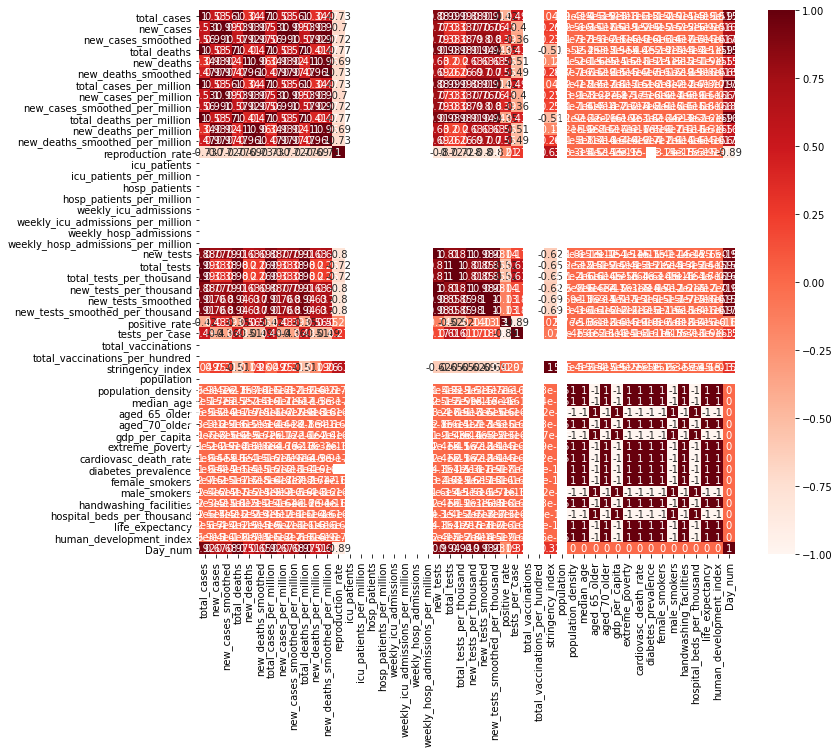

total_cases                        1.000000
new_cases                          0.531592
new_cases_smoothed                 0.564106
total_deaths                       0.996557
total_cases_per_million            1.000000
new_cases_per_million              0.531593
new_cases_smoothed_per_million     0.564106
total_deaths_per_million           0.996557
reproduction_rate                  0.730905
new_tests                          0.879097
total_tests                        0.988232
total_tests_per_thousand           0.988232
new_tests_per_thousand             0.879094
new_tests_smoothed                 0.911482
new_tests_smoothed_per_thousand    0.911495
Day_num                            0.924432
Name: total_cases, dtype: float64
              total_deaths  total_tests
total_deaths      1.000000     0.977496
total_tests       0.977496     1.000000


In [3]:
# Feature selection using Pearson Correlation
plt.figure(figsize=(12,10))
cor = all_data.corr()  # finding correlation between features
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds) #plotting the correlation matrix
plt.show()
# correlation with output variable
cor_target = abs(cor["total_cases"])
# Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
print(relevant_features)
# finding correlation between 2 most likely features
print(all_data[["total_deaths","total_tests"]].corr())

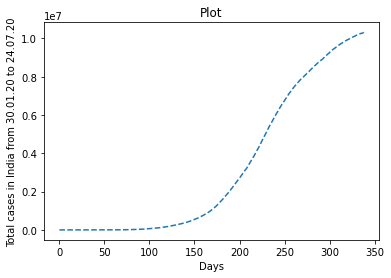

In [4]:
# plot initial cases vs date
y = all_data['total_cases']
x = range(0, len(y))
plt.plot(x,y,'--')
plt.title('Plot')
plt.xlabel('Days')
plt.ylabel('Total cases in India from 30.01.20 to 24.07.20')
plt.show()


In [5]:
# define features and labels
features = ['total_cases', 'Day_num', 'total_deaths']
req_data = all_data[features].astype('float64').apply(lambda x: np.log1p(x)) # apply natural logarithm to all values
req_data.replace([np.inf, -np.inf], 0, inplace=True) # Replace infinities with 0
req_data.dropna(how='any', axis=0, inplace=True)     # drop null values
train_data = req_data.drop(['total_cases'], axis=1)  # drop the target variable so training set contains only features
labels = req_data['total_cases']                     # define target variable
print(labels.shape)  #120 rows


(298,)


In [6]:
# split data
x_train , x_test , y_train , y_test = train_test_split(train_data , labels , test_size = 0.10)

In [7]:
# Create linear regression model
reg = LinearRegression()

# Train the model using the training sets
reg.fit(x_train,y_train)

# Predict on test set
y_pred = reg.predict(x_test)
y_pred = np.expm1(y_pred) # applying exponential to reverse log transformation

# Predict Covid-19 cases for 15th Aug, 2020
FifteenthAugPred = reg.predict(np.log1p(np.array([198,46359])).reshape(1,-1))
print("FifteenthAugPred:", np.expm1(FifteenthAugPred).astype(int))  # applying exponential to reverse log transformation

FifteenthAugPred: [2202017]


In [8]:
# find metrics
y_test = np.expm1(y_test)
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2 score:', np.sqrt(metrics.r2_score(y_test, y_pred)))

MAE: 380724.4854525449
MSE: 366981544156.67426
RMSE: 605790.0165541475
R2 score: 0.985905853862972


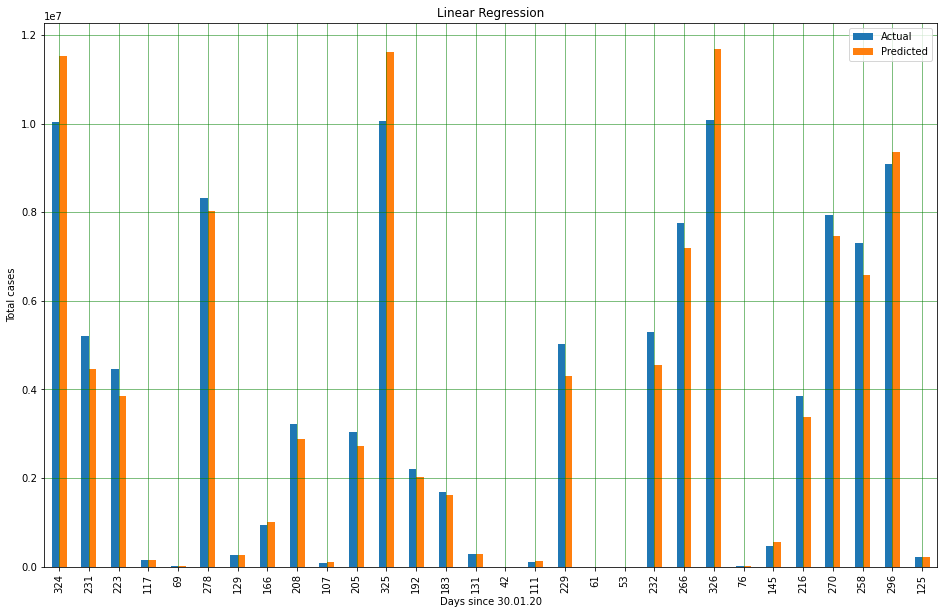

In [9]:
# plot predicted data
data = {'Actual': y_test, 'Predicted': y_pred}
comparison_df = pd.DataFrame(data)
comparison_df.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title("Linear Regression")
plt.xlabel("Days since 30.01.20")
plt.ylabel("Total cases")
plt.show()


In [10]:
# Regularisation using Elastic Net It is a combination of regularization L1 and L2.
model_enet = ElasticNet(normalize=True)
param_list = {"alpha":[1, 0.5, 0.1, 0.001, 0.001, 1e-4],
              "l1_ratio": [0, 0.25, 0.5, 0.75, 1]}

gridCV = GridSearchCV(estimator=model_enet, param_grid=param_list, n_jobs=-1, refit=True)

grid_result = gridCV.fit(x_train, y_train)
predicted =  gridCV.predict(x_test)
predicted = np.expm1(predicted)
print("Best: %f usinf %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.998616 usinf {'alpha': 0.0001, 'l1_ratio': 1}


In [11]:
# Predict Covid-19 cases for 15th Aug, 2020
FifteenthAugPred = gridCV.predict(np.log1p(np.array([198,46359])).reshape(1,-1))
print("FifteenthAugPred using Elastic net:", np.expm1(FifteenthAugPred).astype(int))  # applying exponential to reverse log transformation


FifteenthAugPred using Elastic net: [2199912]


In [12]:
# find metrics
print('MAE:', metrics.mean_absolute_error(y_test, predicted))
print('MSE:', metrics.mean_squared_error(y_test, predicted))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))
print('R2 score:', np.sqrt(metrics.r2_score(y_test, predicted)))

MAE: 381971.8956917416
MSE: 367389440861.25195
RMSE: 606126.5881490862
R2 score: 0.9858900762451055


<bound method NDFrame.head of          Actual     Predicted
324  10031223.0  1.153081e+07
231   5214677.0  4.463966e+06
223   4465863.0  3.857193e+06
117    150793.0  1.526816e+05
69       5916.0  5.557643e+03
278   8313876.0  8.014047e+06
129    257486.0  2.639450e+05
166    936181.0  1.010315e+06
208   3224547.0  2.881703e+06
107     90648.0  9.617730e+04
205   3044940.0  2.718658e+06
325  10055560.0  1.160651e+07
192   2215074.0  2.027764e+06
183   1695988.0  1.615550e+06
131    276146.0  2.861178e+05
42         73.0  7.561300e+01
111    112028.0  1.171026e+05
229   5020359.0  4.309766e+06
61       1397.0  1.305811e+03
53        499.0  4.148242e+02
232   5308014.0  4.545839e+06
266   7761312.0  7.185892e+06
326  10075116.0  1.168049e+07
76      12322.0  1.225649e+04
145    456183.0  5.462450e+05
216   3853406.0  3.373657e+06
270   7946429.0  7.460878e+06
258   7307097.0  6.576960e+06
296   9095806.0  9.362172e+06
125    216824.0  2.202764e+05>


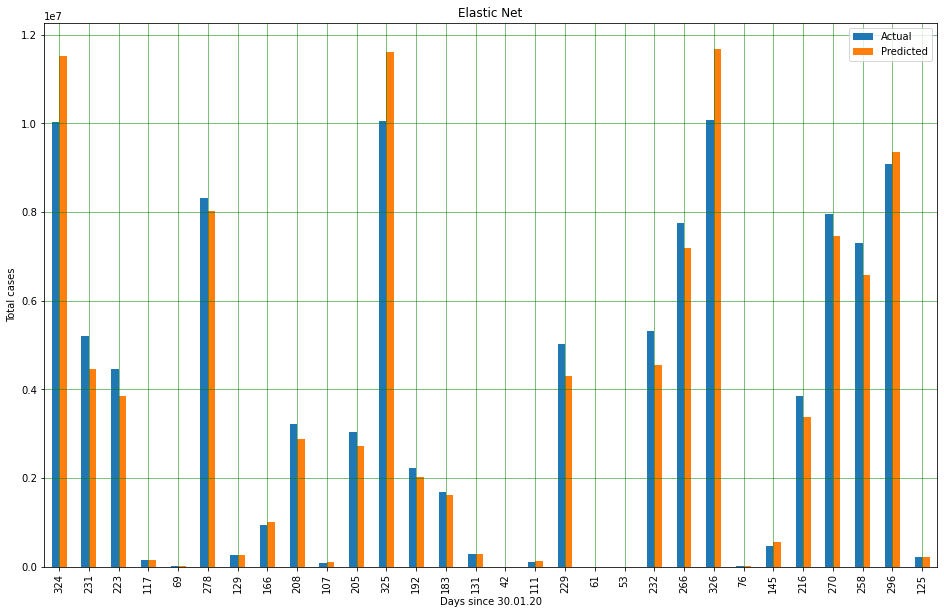

In [13]:
# plot predicted data
data = {'Actual': y_test, 'Predicted': predicted}
comparison_df = pd.DataFrame(data)
print(comparison_df.head)
comparison_df.plot(kind='bar',figsize=(16,10))
plt.title("Elastic Net")
plt.xlabel("Days since 30.01.20")
plt.ylabel("Total cases")
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()